**Bootcamp Alura - Data Science Aplicada**

**Projeto Módulo 1**

Python e pandas para análise de dados reais

Gustavo Hideki Nakamura

**Sobre o projeto**

Durante a exploração dos dados do DATASUS, com foco nos gastos de Produção Hospitalar, a  análise dos gastos per capita mostrou picos pontuais no estado de Pernambuco que poderiam indicar a existência de uma crise sanitária, como um aumento pontual de casos de alguma doença contagiosa.

Esses picos indicavam aumento de mais de 100% dos gastos por habitante em relação a média anterior, além de ultrapassarem as médias de todas as demais unidades da Federação.

O escopo deste projeto é analisar as possíveis causas desses picos de gastos em Pernambuco.


**1. Gastos com procedimentos hospitalares.**

Importando os dados da produção hospitalar. Gastos com procedimentos hospitalares por local de internação.

Valor total por Unidade da Federação e Ano/mês atendimento.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

############################################################################
#Valor total de gastos com atendimentos por ano/mês por unidade da federação
############################################################################
dados = pd.read_csv("/content/A213524189_28_143_208.csv", encoding="ISO-8859-1", skiprows=3, sep=";", skipfooter=12, 
                    thousands=".", decimal=",", engine='python')

colunas_usaveis = dados.mean().index.tolist()
colunas_usaveis.insert(0, "Unidade da Federação")
usaveis = dados[colunas_usaveis]
usaveis = usaveis.set_index("Unidade da Federação")

#retira coluna Total
usaveis = usaveis.drop("Total",axis=1)

#retira pico máximo para ajustar a escala
pico = usaveis.loc['35 São Paulo'].idxmax()
usaveis = usaveis.drop(pico,axis=1)


**2. Dados sobre o tamanho da população.**

Importando os dados da população estimada por Unidade da Federação e Ano.

Período: 1992-1995, 1997-2019.

Estimativas utilizadas pelo TCU para a determinação das cotas do Fundo de Participação dos Municípios. Esses dados estão também disponíveis no Data SUS.

In [ ]:
############################################################################
#População estimada por Unidade da Federação e Ano
#Período: 1992-1995, 1997-2019
############################################################################
populacao = pd.read_csv("/content/A153906189_28_143_208_Populacao.csv", encoding="ISO-8859-1", skiprows=3, sep=";", skipfooter=12, 
                    thousands=".", decimal=",", engine='python')

#set index
populacao = populacao.set_index("Unidade da Federação")

#interpola para 1996
populacao['1996'] = populacao['1995'] + (populacao['1997'] - populacao['1995'])/2

#considera a populacao Ano/Mes = estimativa populacional do Ano correspondente (sem interpolação)
meses = ['Jan','Fev','Mar','Abr','Mai','Jun','Jul','Ago','Set','Out','Nov','Dez']
anos = populacao.columns.sort_values(ascending=True)
for ano in anos:
  for mes in meses:
    coluna = ano + "/" + mes
    populacao[coluna] = populacao[ano]
  populacao = populacao.drop(ano,axis=1)

#retira [ano/mes] dos gastos sem dados de populacao
for ano_mes in usaveis.columns:
  if ano_mes not in populacao.columns:
    usaveis = usaveis.drop(ano_mes,axis=1)
#-> sobram 27 x 148

#retira [ano/mes] da populacao sem dados de gastos
for ano_mes in populacao.columns:
  if ano_mes not in usaveis.columns:
    populacao = populacao.drop(ano_mes,axis=1)    
#-> sobram 27 x 148: OK

**3. Gastos por habitante - O que aconteceu em Pernambuco?**

Ao plotar as informações dos gastos per capita ao longo do tempo, observa-se que em dois momentos os gastos de Pernambuco atingem um pico, mais que dobrando em relação à média anterior. Além disso, essas médias ultrapassaram todos os estados.


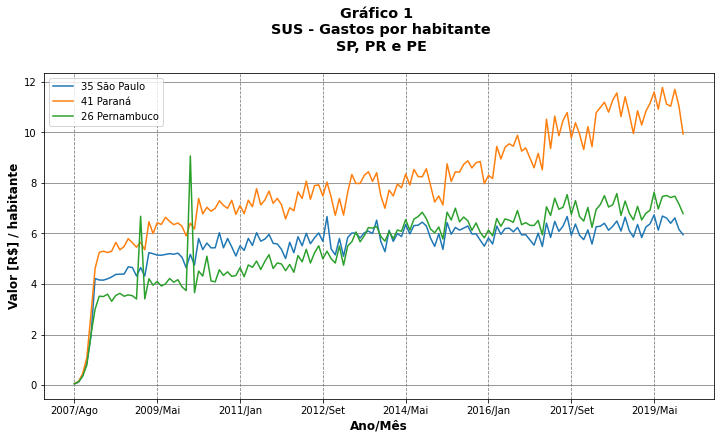

In [ ]:
#gastos e populacao possuem a mesma ordem no index -> divisão direta sem necessidae de reordenar linhas
ax = (usaveis/populacao).T[["35 São Paulo","41 Paraná","26 Pernambuco"]].plot(figsize=(12,6))

ax.grid(b=True, axis='y', which='major', color='grey', linestyle='-')
ax.grid(b=True, axis='x', which='major', color='grey', linestyle='--')

plt.title('Gráfico 1 \n SUS - Gastos por habitante\n SP, PR e PE\n', weight='bold', fontsize='x-large' )
plt.ylabel("Valor [R$] / habitante",weight='bold',fontsize='large')
plt.xlabel("Ano/Mês",weight='bold',fontsize='large')
plt.legend(loc="upper left")
plt.show()

**Comentário:**

Usamos para comparação o estado de São Paulo, com os maiores  gastos e a maior população, e o estado do Paraná que possui a maior média histórica de gasto per capita.

**4. Determinando os meses de pico**

Para determinar os meses de pico, o período entre o final de 2008 e início de 2010 é analisado.
Conforme o gráfico 2 gerado abaixo os meses de janeiro de 2009 e janeiro de 2010 são o objeto da análise.

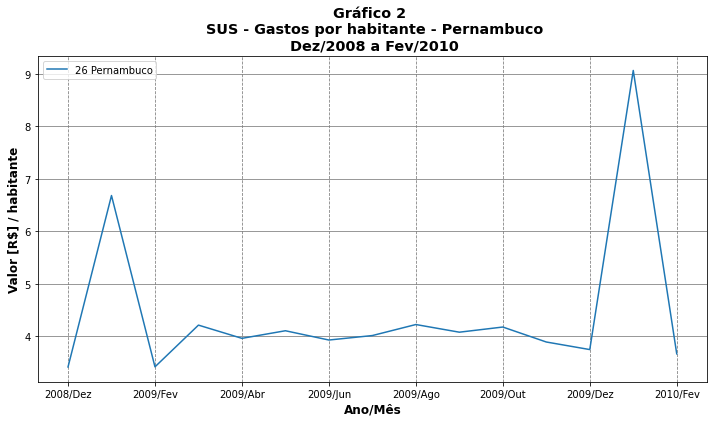

In [ ]:
ax = (usaveis/populacao).T["26 Pernambuco"][15:30].plot(figsize=(12,6))

ax.grid(b=True, axis='y', which='major', color='grey', linestyle='-')
ax.grid(b=True, axis='x', which='major', color='grey', linestyle='--')

plt.title('Gráfico 2 \n SUS - Gastos por habitante - Pernambuco\n Dez/2008 a Fev/2010', weight='bold', fontsize='x-large' )
plt.ylabel("Valor [R$] / habitante",weight='bold',fontsize='large')
plt.xlabel("Ano/Mês",weight='bold',fontsize='large')
plt.legend(loc="upper left")
plt.show()

**5. Análise dos valores por procedimento**

Importando os dados sobre os valores aprovados por Procedimento e Ano/mês de atendimento para o estado de Pernambuco.

O objetivo é identificar o(s) procedimento(s) que causaram o aumento repentino de gastos nos meses definidos no gráfico anterior.

In [ ]:
############################################################################
#Procedimentos Pernambuco
############################################################################
dadosPE = pd.read_csv("/content/A141514189_28_143_208_Pernambuco.csv", encoding="ISO-8859-1", skiprows=3, sep=";", skipfooter=6, 
                    thousands=".", decimal=",", engine='python')
#2577 rows × 181 columns

dadosPE = dadosPE.set_index("Procedimento")

#foco nos meses de pico
dadosPicos = dadosPE[['2009/Jan','2010/Jan']]

#limpa dados
dadosPicos = dadosPicos.replace(to_replace='-', value=0)
dadosPicos = dadosPicos.replace(to_replace='0.0', value=0)
dadosPicos['2009/Jan'] = pd.to_numeric(dadosPicos['2009/Jan'], errors='coerce')
dadosPicos['2010/Jan'] = pd.to_numeric(dadosPicos['2010/Jan'], errors='coerce')

#ordena os procedimentos pelo valor total de gastos - 10 primeiros
(dadosPicos['2009/Jan'] + dadosPicos['2010/Jan']).sort_values(ascending=False).head(10)

Procedimento
0303170093 TRATAMENTO EM PSIQUIATRIA (POR DIA)                                                                     70376000.00
0303130075 TRATAMENTO DE PACIENTE SOB CUIDADOS PROLONGADOS POR ENFERMIDADES OSTEOMUSCULARES E DO TECIDO CONJUNT     5557770.13
0802010083 DIARIA DE UNIDADE DE TERAPIA INTENSIVA ADULTO (UTI II)                                                   4727310.77
0310010039 PARTO NORMAL                                                                                             4670523.62
0411010034 PARTO CESARIANO                                                                                          2452661.21
0303140151 TRATAMENTO DE PNEUMONIAS OU INFLUENZA (GRIPE)                                                            2247419.50
0411010026 PARTO CESARIANO EM GESTACAO DE ALTO RISCO                                                                1229767.32
0303010061 TRATAMENTO DE DOENÇAS INFECCIOSAS INTESTINAIS                                          

**Primeiros achados**

Na tabela acima encontramos o procedimento "TRATAMENTO EM PSIQUIATRIA (POR DIA)" como principal ofensor dos gastos. Somando os dois meses em análise obtemos mais de R$70 milhões, uma quantia que ultrapasa em mais de 12 vezes o segundo procedimento mais executado.

Se esperávamos econtrar um surto de alguma doença contagiosa ou alguma crise sanitária, não podemos mais manter essa hipótese.

O que também chama a atenção é que o segundo procedimento mais executado trata de [doenças crônicas das mais váriadas origens](https://www.qualcid.com.br/procedimento/0303130075/tratamento-de-paciente-sob-cuidados-prolongados-por-enfermidades-osteomusculares-e-do-tecido-conjuntivo) como artrose, osteoporose etc. 

Os peso dos gastos com tratamento em psiquiatria são suficientes para voltarmos nossas atenções para esse procedimento. Vamos continuar sua análise.

**6. Dados de TRATAMENTO EM PSIQUIATRIA para todo o Brasil**

Importando os gastos de valor aprovado por Unidade da Federação e Ano/mês atendimento.

Procedimento: 0303170093 TRATAMENTO EM PSIQUIATRIA (POR DIA)


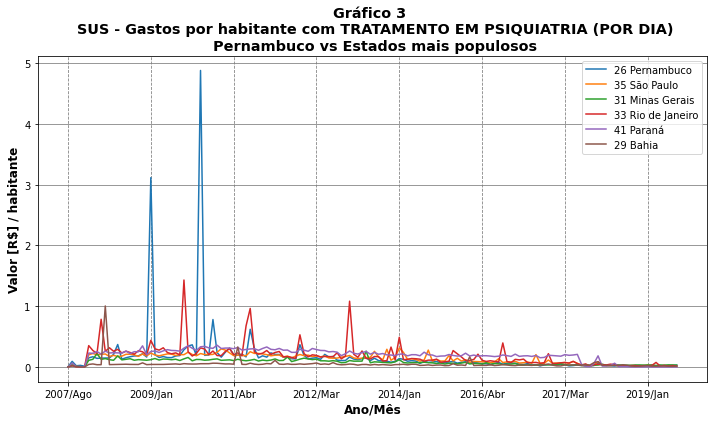

In [ ]:
############################################################################
#Procedimentos Brasil
#Valor aprovado por Unidade da Federação e Ano/mês atendimento
#Procedimento: 0303170093 TRATAMENTO EM PSIQUIATRIA (POR DIA)
#Período:Jan/2008-Mar/2021
############################################################################
dadosBR = pd.read_csv("/content/A155210189_28_143_208_BR_PSIQUIATRIA.csv", encoding="ISO-8859-1", skiprows=4, sep=";", skipfooter=6, 
                    thousands=".", decimal=",", engine='python')
#25 rows × 280 columns
procedimentosBR = dadosBR[colunas_usaveis]
procedimentosBR = procedimentosBR.set_index("Unidade da Federação")
procedimentosBR = procedimentosBR.drop("Total", axis=1)
procedimentosBR = procedimentosBR.drop(pico,axis=1)

#limpa dados
procedimentosBR = procedimentosBR.replace(to_replace='-', value=0)
for col in procedimentosBR[1:].columns:
  procedimentosBR[col] = pd.to_numeric(procedimentosBR[col], errors='coerce')

#Pernambuco vs estados brasileiros mais populosos
estados = ["26 Pernambuco","35 São Paulo","31 Minas Gerais","33 Rio de Janeiro","41 Paraná","29 Bahia"]
ax = ((procedimentosBR.T[estados])/(populacao.T[estados])).plot(figsize=(12,6))
ax.grid(b=True, axis='y', which='major', color='grey', linestyle='-')
ax.grid(b=True, axis='x', which='major', color='grey', linestyle='--')

plt.title('Gráfico 3 \n SUS - Gastos por habitante com TRATAMENTO EM PSIQUIATRIA (POR DIA)\n Pernambuco vs Estados mais populosos', weight='bold', fontsize='x-large' )
plt.ylabel("Valor [R$] / habitante",weight='bold',fontsize='large')
plt.xlabel("Ano/Mês",weight='bold',fontsize='large')
plt.legend(loc="upper right")
plt.show()

**Análise:**

Considerando os estados mais populosos do Brasil, observa-se no Rio de Janeiro uma incidência maior de gastos por habitante com Psiquiatria, mas nada similar ao o que ocorreu em Pernambuco.

Fora este dado, não observa-se gastos relevantes nos demais estados analisados.

**Conclusões:**

Descartamos previamente a hipótese de crise com doenças contagiosas e transmissíveis.

Os gastos per capita de Pernambuco com tratamento em psiquiatria não possuem paralelo com os dados dos demais estados.

Levantamos uma nova hipótese de transferência de hospitais ou pacientes de psquiatria para a rede pública. Neste caso novas linhas de investigação devem ser seguidas.

